# 1. Scattering network design

Welcome to this tutorial on designing a seismic scattering network for the task
at hand. In this Jupyter notebook, we will see the role and how to choose the
parameters of the scattering network with illustrations. The parameter selection
relies on the studies for clustering various types of seismic signals from
continuous seismic data (see e.g., Andén and Mallat
[2014](https://arxiv.org/abs/1304.6763), Seydoux et al.
[2020](https://www.nature.com/articles/s41467-020-17841-x), and Steinmann et al.
[2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455),
[2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL098854)).
This notebook introduces the basic concepts of scattering networks and then
move on to implementing the technique using Python and the
[scatseisnet](https://github.com/scatseisnet/scatseisnet) library.

Made in 2022 by Léonard Seydoux and René Steinmann.

This notebook uses the __matplotlib__ library for plotting, please run the cell below if matplotlib is not installed.

In [33]:
# %pip install matplotlib


In [34]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork

## Select parameters

The following cell defines the meta parameter of the network. The parameters are the ones used in the paper Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455)) and are better argued in the paper. In this example, the network implements only two layers (i.e., two filter banks). Following Andén and Mallat ([2014](https://arxiv.org/abs/1304.6763)), adding more layers may only marginally impact the downstream task, althgouh we suggest to try with various number of layers. 

- The main parameter, the data __samling rate__ (`SAMPLING_RATE`, Hz) defines all the scales (in time and frequency). By default, if `None`, the sampling rate is unitary, which means that the scattering network also works with reduced dimensions. This should be given by the user or from the data.

- The __segment duration__ (`SEGMENT`, in seconds) which is used later to chunk the data into pieces before passing it to the scattering network. This defines the temporal support of the wavelet for now, in order to allow for faster computation. After Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455)), we chose this parameter such as the largest signal we seek for in the continuous data is half-way shorter than the window size. If the signal is continuous and self-similar, this may not apply. Note that we perform the pooling operation over the entire segment later on. The pooling type is settable a the transform moment, so the same scattering network can be used with multiple pooling types.  

- The __scattering network__ properties are gathered into dictionaries within the `BANK` tuple, with keyword arguments passed to the `sn.wavelets.ComplexMorletBank` object:
    - the number of `octaves` ($J$, `int`) covered by the filter banks per layer. This defines the frequency range of analysis of the input data, from the Nyquist frequency $f_N$ down to $f_N/2^J$, and should be decided according to the frequency range of interest for the task.
    - the `resolution` ($Q$, `int`) represents the number of wavelets for each octave, so the frequency resolution of the filterbank. This should be large for the first layer (dense) and small for the other layers (sparse), as indicated in Andén and Mallat ([2014](https://arxiv.org/abs/1304.6763)).
    - the `quality` factor (float) is the ratio between the center frequency of
      every wavelet $f$ and the bandwidth $\delta f$. Because we work with
      constant-Q filters, this is defined from the entire filter bank. The lower
      the quality factor, the more redundant the information in the scattering
      coefficients. We suggest using a quality factor 1 at the first layer, and
      a larger at the remaining layers.
    

In [35]:
segment_duration_seconds = 100.0
sampling_rate_hertz = 50.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 2, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

# Yoram selects filterbanks to look for tremor. 
and now change something else


## Create scattering network

We instantiate the network from the meta parameters defined in the previous cell. The following cell allows defining the scattering network graph. If the graph is defined with the CuPy library, the graph is not compiled until the first run of the network via the `.transform()` method. Otherwise, it is defined in NumPy and behave like a function.

In [36]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=5000, sampling_rate=50.0, len=2)
ComplexMorletBank(bins=5000, octaves=2, resolution=4, quality=1, sampling_rate=50.0, len=8)
ComplexMorletBank(bins=5000, octaves=5, resolution=2, quality=3, sampling_rate=50.0, len=10)


Now we can save the scattering network as is in order to leter use it to transform segmented data into scattering coefficients. We here suggest to use the built-in Pickle Python library for that, althgough other strategies would likely work fine as well. Note that the Pickle library allow to serialize objects with methods and attributes included (with the `pickle.HIGHEST_PROTOCOL` enabled).

In [37]:
dirpath_save = "../example"

# Create directory to save the results
os.makedirs(dirpath_save, exist_ok=True)

# Save the scattering network with Pickle
filepath_save = os.path.join(dirpath_save, "GL_scattering_network_test_yor.pickle")
with open(filepath_save, "wb") as file_save:
    pickle.dump(network, file_save, protocol=pickle.HIGHEST_PROTOCOL)
    

## Vizualize the filter banks

We can easily access and show the filter banks. These should be observed in order to ensure that they are correctly defined.

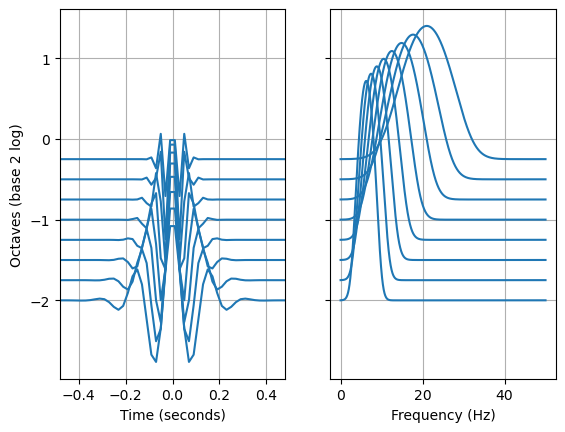

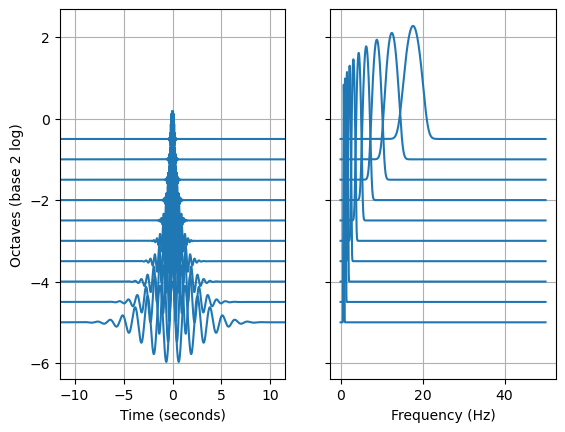

In [38]:
# Loop over network layers
for bank in network.banks:

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):

        # Time domain
        ax[0].plot(bank.times, wavelet.real.get() + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum.get()) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[0].grid()
    #ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()


__First layer__: in the time domain, the mother wavelet at highest frequency (located at the octave 0 - 1/$Q$, where $Q$ is the number of wavelets per octavte) has a duration of about 0.25 seconds. In the frequency domain, we see that its corresponding frequency bandwidth is between ca. 8 and 25 Hz, with a center frequency of about 20 Hz. The wavelet bank then covers all the frequencies down to ca. 0.9 Hz, with a typical duration of about 1 second. This indicates that the signals we will be able to analyse later are located between 0.9 and 25 Hz. 

__Second layer__: while the first layer allows to select the frequency range of interest, the second-order wavelet bank will be crucial to evaluate the envelope modulations and durations. We also use a sparser wavelet bank, ranging from 0.9 to 20 Hz with less wavelets per octaves and non-overlapping frequency supports.